# PPO-clip algorithm

In [8]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import abc
import tensorflow as tf
import numpy as np

from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec, tensor_spec
from tf_agents.environments import wrappers
from tf_agents.trajectories import time_step as ts
from tf_agents.trajectories import policy_step as ps
from tf_agents.typing import types
from tf_agents.metrics import py_metrics
from tf_agents.metrics import tf_metrics
from tf_agents.drivers import py_driver
from tf_agents.drivers import tf_driver
from tf_agents.drivers import dynamic_episode_driver
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.drivers import dynamic_step_driver
from tf_agents.policies import py_tf_eager_policy
from tf_agents.networks import actor_distribution_network
from tf_agents.networks import value_network
from tf_agents.agents import PPOClipAgent
from tf_agents.utils import common as cmn

import matplotlib.pyplot as plt
import qutip
from qutip import sigmap, expect

import random

import sys
sys.path.append('../')
from common.common import get_average_return, extract_single_action_policy

%matplotlib inline

* System parameters

In [9]:
T = 3.5 # terminal time step
max_steps = 30 # number of time steps
random.seed(1991)

* Create training and evaluation environments and define actions

In [10]:
# validate environment
from environments.qubit_env import QubitResonantContEnv

# define actions
# TODO: actions can be continuous within a range of course 
# actions will be the change in the magnetic field
max_Ω = 1.0

environment = QubitResonantContEnv(T, max_steps, max_Ω, fidelity_threshold = 0.9999, verbose_fg = False)
eval_environment = QubitResonantContEnv(T, max_steps, max_Ω, fidelity_threshold = 0.9999, verbose_fg = False)

train_env = tf_py_environment.TFPyEnvironment(environment)
eval_env = tf_py_environment.TFPyEnvironment(eval_environment)

In [11]:
fc_layer_params = (100, 75)
learning_rate = 1e-3
replay_buffer_capacity = 10000
num_iterations = 1000
nb_episodes = 1
eval_interval = 10
checkpoint_dir = "/home/dkoytrom/Msc_Quantum_Computing_Quantum_Technologies/Master_Thesis/algorithms/classical/Reinforcement_learning/checkpoints/ppo_clip_qubit_resonant_cont_e-4_error/"

In [12]:
actor_network = actor_distribution_network.ActorDistributionNetwork(
    input_tensor_spec = train_env.observation_spec(),
    output_tensor_spec = train_env.action_spec(),
    fc_layer_params = fc_layer_params,
    name = "Policy",
)

# use tha Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

train_step_counter = tf.Variable(0)

value_net = value_network.ValueNetwork(
    input_tensor_spec = train_env.observation_spec(),
    fc_layer_params = (100, 50, ),
    name = 'ValueNet'
) 

agent = PPOClipAgent(
    time_step_spec = train_env.time_step_spec(),
    action_spec = train_env.action_spec(),
    actor_net = actor_network,
    value_net = value_net,
    optimizer = optimizer,
    train_step_counter = train_step_counter,
    value_clipping = 0.2
)

agent.initialize()

In [13]:
# collect trajectories
import reverb
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils

table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size = replay_buffer_capacity,
    sampler = reverb.selectors.Uniform(),
    remover = reverb.selectors.Fifo(),
    rate_limiter = reverb.rate_limiters.MinSize(1),
    signature = replay_buffer_signature
)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name = table_name,
    sequence_length = None,
    local_server = reverb_server
)

rb_observer = reverb_utils.ReverbAddEpisodeObserver(
    replay_buffer.py_client,
    table_name,
    replay_buffer_capacity
)

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = cmn.function(agent.train)

# Reset the train step.
# agent.train_step_counter.assign(0)

# create a driver which will run the simulations and collect tha dataset for our training
collect_driver = py_driver.PyDriver(
    environment,
    py_tf_eager_policy.PyTFEagerPolicy(agent.collect_policy, use_tf_function = True),
    observers = [rb_observer],
    max_episodes = nb_episodes
)

# create checkpointer to load training and continue
""" checkpointer = cmn.Checkpointer(
    ckpt_dir = checkpoint_dir,
    max_to_keep = 1,
    agent = agent,
    policy = agent.policy,
    replay_buffer = replay_buffer,
)

checkpointer.initialize_or_restore() """

[reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /tmp/tmpz5ib9oxd.
[reverb/cc/platform/tfrecord_checkpointer.cc:565] Loading latest checkpoint from /tmp/tmpz5ib9oxd
[reverb/cc/platform/default/server.cc:71] Started replay server on port 33553
[reverb/cc/platform/default/server.cc:84] Shutting down replay server


' checkpointer = cmn.Checkpointer(\n    ckpt_dir = checkpoint_dir,\n    max_to_keep = 1,\n    agent = agent,\n    policy = agent.policy,\n    replay_buffer = replay_buffer,\n)\n\ncheckpointer.initialize_or_restore() '

In [14]:
avg_returns = [get_average_return(eval_env, agent.policy, 10)]

for _ in range(num_iterations):
    initial_time_step = environment.reset()
    collect_driver.run(initial_time_step)

    # create dataset from trajectories
    dataset = replay_buffer.as_dataset(sample_batch_size = 1)
    iterator = iter(dataset)

    trajectories , _ = next(iterator)

    # train 
    train_loss = agent.train(experience = trajectories)

    replay_buffer.clear()

    step = agent.train_step_counter.numpy()

    if step % 50 == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss.loss))

    if step % eval_interval == 0:
        avg_return = get_average_return(eval_env, agent.policy, 10)
        avg_returns.append(avg_return)


[reverb/cc/client.cc:165] Sampler and server are owned by the same process (33937) so Table uniform_table is accessed directly without gRPC.


step = 50: loss = 30.332361221313477


[reverb/cc/client.cc:165] Sampler and server are owned by the same process (33937) so Table uniform_table is accessed directly without gRPC.


step = 100: loss = 39.95536422729492
step = 150: loss = 34.35211181640625


[reverb/cc/client.cc:165] Sampler and server are owned by the same process (33937) so Table uniform_table is accessed directly without gRPC.


step = 200: loss = 137.34776306152344
step = 250: loss = 382.6946716308594
step = 300: loss = 12.281927108764648
step = 350: loss = 25.649959564208984


[reverb/cc/client.cc:165] Sampler and server are owned by the same process (33937) so Table uniform_table is accessed directly without gRPC.


step = 400: loss = 35.05965805053711
step = 450: loss = 23.350812911987305
step = 500: loss = 8.876254081726074
step = 550: loss = 1.6499674320220947
step = 600: loss = 0.0684380903840065
step = 650: loss = 0.0915427878499031
step = 700: loss = -0.003644753247499466
step = 750: loss = 0.042242102324962616


[reverb/cc/client.cc:165] Sampler and server are owned by the same process (33937) so Table uniform_table is accessed directly without gRPC.


step = 800: loss = 0.005893109366297722
step = 850: loss = 0.018471477553248405
step = 900: loss = 0.0027304673567414284
step = 950: loss = 0.010188919492065907
step = 1000: loss = 0.006885330192744732
step = 1050: loss = -0.06627870351076126
step = 1100: loss = -0.08901108801364899
step = 1150: loss = -0.1232154443860054
step = 1200: loss = -0.04809778183698654
step = 1250: loss = -0.04897288233041763
step = 1300: loss = 0.002372617367655039
step = 1350: loss = 0.0017316807061433792
step = 1400: loss = -0.0008756567258387804
step = 1450: loss = 0.0007359052542597055
step = 1500: loss = 0.00021352199837565422
step = 1550: loss = 0.0009329713648185134


[reverb/cc/client.cc:165] Sampler and server are owned by the same process (33937) so Table uniform_table is accessed directly without gRPC.


step = 1600: loss = -0.00011896644718945026
step = 1650: loss = -0.00046271621249616146
step = 1700: loss = 0.00044872495345771313
step = 1750: loss = 0.00047303270548582077
step = 1800: loss = -0.005682812072336674
step = 1850: loss = -0.00039050134364515543
step = 1900: loss = -0.0016012474661692977
step = 1950: loss = -0.0038340240716934204
step = 2000: loss = -0.003504530293866992
step = 2050: loss = -0.0035042488016188145
step = 2100: loss = -0.0018451891373842955
step = 2150: loss = -0.0032400607597082853
step = 2200: loss = -0.004025875590741634
step = 2250: loss = -0.0015971511602401733
step = 2300: loss = -0.0014338900800794363
step = 2350: loss = -0.006036127917468548
step = 2400: loss = -0.0013853434938937426
step = 2450: loss = -0.004887964576482773
step = 2500: loss = -0.0015313162002712488
step = 2550: loss = -0.004489029757678509
step = 2600: loss = -0.0014159337151795626
step = 2650: loss = -0.001362311071716249
step = 2700: loss = -0.002951725386083126
step = 2750: los

[reverb/cc/client.cc:165] Sampler and server are owned by the same process (33937) so Table uniform_table is accessed directly without gRPC.


step = 3200: loss = -0.07577761262655258
step = 3250: loss = -0.0835571363568306
step = 3300: loss = -0.07654546946287155
step = 3350: loss = -0.12804347276687622
step = 3400: loss = -0.18111281096935272
step = 3450: loss = 6.599056243896484
step = 3500: loss = -0.09912282228469849
step = 3550: loss = 7.591285228729248
step = 3600: loss = 3.412459373474121
step = 3650: loss = 0.6492060422897339
step = 3700: loss = -0.6325058341026306
step = 3750: loss = -0.2468046396970749
step = 3800: loss = -0.0687408447265625
step = 3850: loss = -0.03934549167752266
step = 3900: loss = -0.1114596500992775
step = 3950: loss = -0.16115671396255493
step = 4000: loss = -0.07682447880506516
step = 4050: loss = -1.074720025062561
step = 4100: loss = -0.5400509238243103
step = 4150: loss = -0.10899761319160461
step = 4200: loss = -0.07014258205890656
step = 4250: loss = 0.04819145053625107
step = 4300: loss = -0.3780878186225891
step = 4350: loss = -0.15711766481399536
step = 4400: loss = 0.034663677215576

[reverb/cc/client.cc:165] Sampler and server are owned by the same process (33937) so Table uniform_table is accessed directly without gRPC.


step = 6400: loss = -0.33838003873825073
step = 6450: loss = -0.14662796258926392
step = 6500: loss = -0.08253131061792374
step = 6550: loss = -0.09352331608533859
step = 6600: loss = 0.0749216228723526
step = 6650: loss = -0.10808701068162918
step = 6700: loss = 0.03237602114677429
step = 6750: loss = 0.024675922468304634
step = 6800: loss = -0.18838587403297424
step = 6850: loss = -0.09028445929288864
step = 6900: loss = -0.043707288801670074
step = 6950: loss = -0.1742338389158249
step = 7000: loss = -0.06694549322128296
step = 7050: loss = -0.16375364363193512
step = 7100: loss = -0.12866567075252533
step = 7150: loss = -0.0007331949309445918
step = 7200: loss = -0.06716760993003845
step = 7250: loss = -0.029535001143813133
step = 7300: loss = 0.040423888713121414
step = 7350: loss = -0.27312013506889343
step = 7400: loss = -0.04550743103027344
step = 7450: loss = 0.012628445401787758
step = 7500: loss = -0.0819157287478447
step = 7550: loss = -0.052802979946136475
step = 7600: los

[reverb/cc/client.cc:165] Sampler and server are owned by the same process (33937) so Table uniform_table is accessed directly without gRPC.


step = 12800: loss = -0.2128588706254959
step = 12850: loss = -0.21025095880031586
step = 12900: loss = -0.006249606609344482
step = 12950: loss = -0.1422276496887207
step = 13000: loss = -0.037165459245443344
step = 13050: loss = -0.24780651926994324
step = 13100: loss = -0.545315682888031
step = 13150: loss = -0.4822966754436493
step = 13200: loss = -0.15631812810897827
step = 13250: loss = -0.05733301490545273
step = 13300: loss = 0.011706356890499592
step = 13350: loss = -0.0197621937841177
step = 13400: loss = -0.06390281766653061
step = 13450: loss = -0.11179652810096741
step = 13500: loss = -0.12718668580055237
step = 13550: loss = -0.8726182579994202
step = 13600: loss = -0.7430301308631897
step = 13650: loss = -0.14946725964546204
step = 13700: loss = -0.06862480938434601
step = 13750: loss = -0.22943858802318573
step = 13800: loss = -0.46060144901275635
step = 13850: loss = 0.09057941287755966
step = 13900: loss = -0.23065392673015594
step = 13950: loss = -0.2078024446964264


In [15]:
# checkpointer.save(train_step_counter)

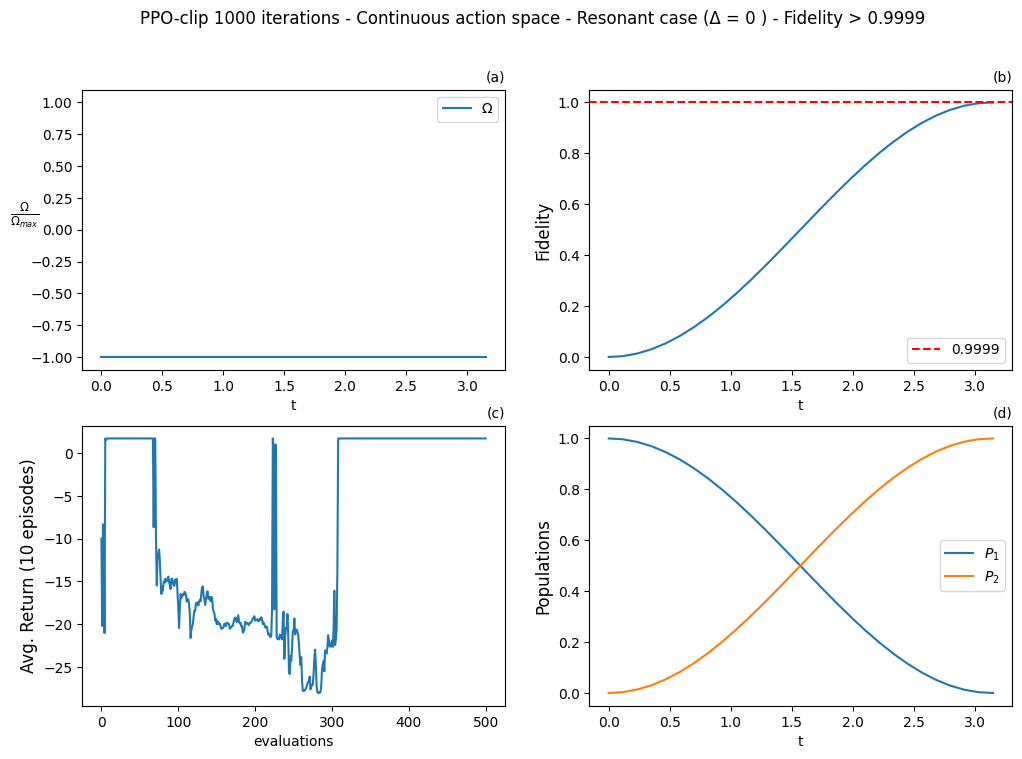

In [17]:
greedy_actions, optimal_omegas, states, fidelities = extract_single_action_policy(environment, agent)

population2 = expect(sigmap().dag() * sigmap(), states)
population1 = 1 - population2

time_span = np.arange(len(optimal_omegas))
time_span = [t * T / max_steps for t in time_span]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_figheight(8)
fig.set_figwidth(12)
fig.suptitle(f'PPO-clip {num_iterations} iterations - Continuous action space - Resonant case (Δ = 0 ) - Fidelity > 0.9999')

ax1.step(time_span, optimal_omegas, where = 'post', label = 'Ω')
ax1.set_ylabel(r"$\frac{\Omega}{\Omega_{max}}$", rotation = 0, fontsize = 12)
ax1.set_ylim((-1.1, 1.1))
ax1.set_xlabel(f"t")
ax1.set_title("(a)", loc = "right", fontsize = 10)
ax1.legend()

ax2.plot(time_span, fidelities)
ax2.axhline(y = 0.9999, color = 'r', linestyle = '--', label = '0.9999')
ax2.set_ylabel("Fidelity", rotation = 90, fontsize = 12)
ax2.set_xlabel(f"t")
ax2.set_title("(b)", loc = "right", fontsize = 10)
ax2.legend(loc = 'lower right')

ax4.plot(time_span, population1, label = r"$P_1$")
ax4.plot(time_span, population2, label = r"$P_2$")
ax4.set_ylabel("Populations", rotation = 90, fontsize = 12)
ax4.set_xlabel(f"t")
ax4.set_title("(d)", loc = "right", fontsize = 10)
ax4.legend()

time_span3 = range(len(avg_returns))
ax3.plot(time_span3, avg_returns)
ax3.set_ylabel("Avg. Return (10 episodes)", rotation = 90, fontsize = 12)
ax3.set_xlabel(f"evaluations")
ax3.set_title("(c)", loc = "right", fontsize = 10)
plt.show()